In [1]:
import torch
from torch import nn
import torch.optim as optim

import pickle

import numpy as np
import matplotlib.pyplot as plt

In [160]:
device = torch.device('cpu')

In [161]:
train_fh = open('data/lego-train.pickle', 'rb')
test_fh = open('data/lego-test.pickle', 'rb')


In [162]:
train_data = pickle.load(train_fh)
test_data = pickle.load(test_fh)

In [11]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

In [12]:
train_data_X = [img for (img, _) in train_data]
train_data_y = [lbl for (_, lbl) in train_data]

test_data_X = [img for (img, _) in test_data]
test_data_y = [lbl for (_, lbl) in test_data]

In [13]:
img_transforms = transforms.Compose([
#    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

In [14]:
def get_dataset(X, y):
    tensor_x = torch.Tensor(X) # transform to torch tensor
    tensor_x = img_transforms(tensor_x)
    tensor_y = torch.Tensor(y).long()

    dataset = TensorDataset(tensor_x,tensor_y) # create your datset
    return dataset


In [163]:
train_dataset = get_dataset(train_data_X, train_data_y)
test_dataset = get_dataset(test_data_X, test_data_y)

In [164]:
# For humans:
class_names = ['2x3 Brick', '2x2 Brick', '1x3 Brick', '2x1 Brick', '1x1 Brick', '2x2 Macaroni', '2x2 Curved End', 'Cog 16 Tooth', '1x2 Handles', '1x2 Grill']

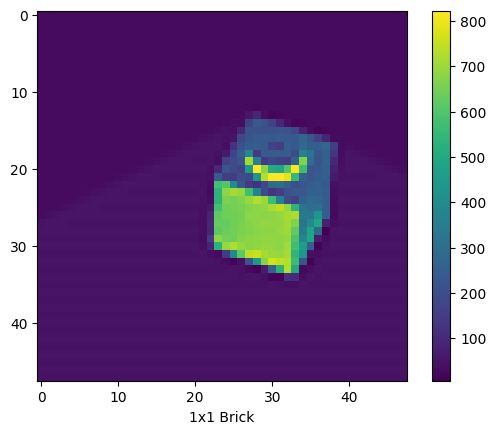

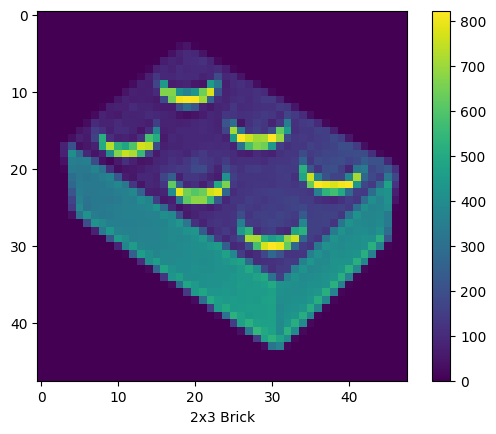

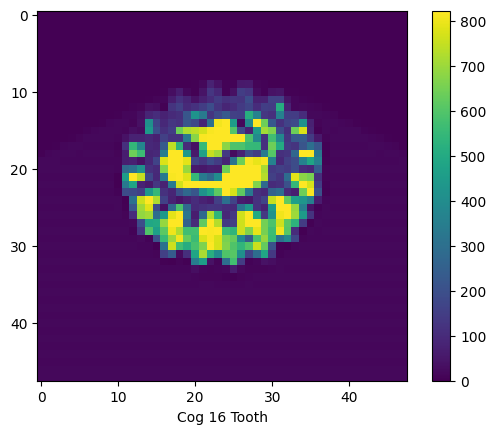

In [165]:
i = 0
for images_data, label_data in train_dataloader:
    i+=1
    if i>3: break
    plt.figure()
    plt.imshow(images_data[0].numpy())
    plt.colorbar()
    plt.xlabel(class_names[label_data[0]])
    plt.show()


In [172]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
def train(net, train_loader, device, num_epochs, learning_rate):
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []


    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_num, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.permute(0, 3, 1, 2).to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = loss_function(outputs, labels)
    
            loss.backward()

            optimizer.step()

            running_loss += loss.item()

            # Calculate batch Accuracy
            _, predicted = outputs.max(1)
            batch_total = labels.size(0)
            batch_correct = predicted.eq(labels).sum().item()
            batch_acc = batch_correct/batch_total

            total += batch_total
            correct += batch_correct

        # Print the evaluation metric and reset it for the next epoch
        acc = correct/total 
        acc_history.append(acc)

    return acc_history


In [173]:
def build_NN():
    net = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(48*48, 128),
        torch.nn.Sigmoid(),
        torch.nn.Linear(128, 64),
        torch.nn.Sigmoid(),
        torch.nn.Linear(64, 10)
    )
    
    net.apply(init_weights)
    
    return net

In [185]:
def print_history(history, title=""):
    plt.figure(figsize=(7, 4))
    plt.plot(history,color='orange')
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

NN Model


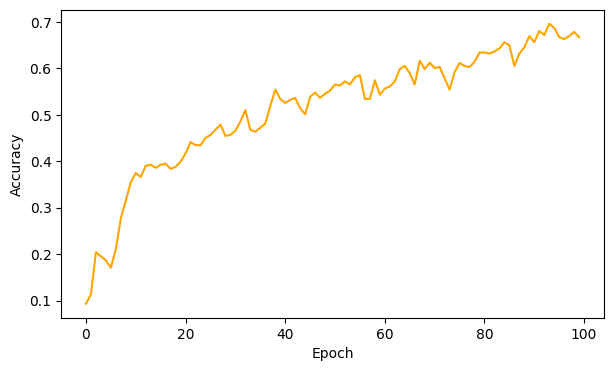

In [186]:
net = build_NN()
BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE)

hist = train(net, train_dataloader, device, EPOCHS, LR)
print("NN Model")
print_history(hist)

LeNet Model


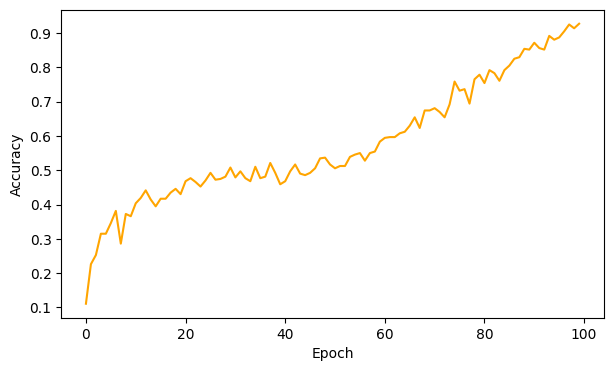

In [187]:
def build_lenet():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
            
    net = torch.nn.Sequential(
        # Input: 48x48
    
        torch.nn.Conv2d(1, 6, 5, padding=(2,2)), # out: 48x48x6
        torch.nn.ReLU(),
        
        torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), # out: 24x24x6
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(6, 16, 5), # out: 20x20x16
        torch.nn.ReLU(),

        torch.nn.AvgPool2d(kernel_size=(2,2), stride=(2,2)), # out: 10x10x16

        torch.nn.Flatten(),
        
        torch.nn.Linear(10*10*16, 120),
        torch.nn.Sigmoid(),
        torch.nn.Linear(120, 84),
        torch.nn.Sigmoid(),
        torch.nn.Linear(84, 10)
    )
  
    net.apply(init_weights)
    return net
lenet = build_lenet()
hist_lenet = train(lenet, train_dataloader, device, EPOCHS, LR)
print("LeNet Model")
print_history(hist_lenet)

AlexNet Model


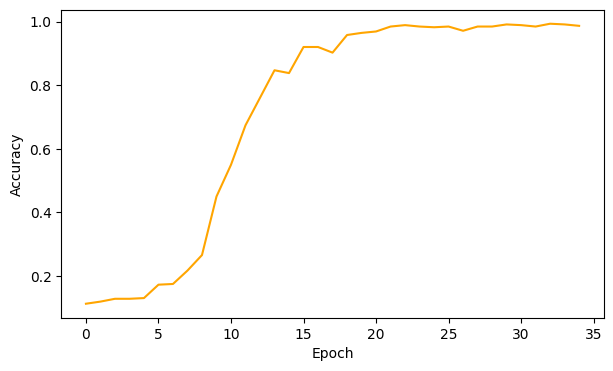

In [188]:
def build_alexnet():
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)

    net = torch.nn.Sequential(
        # Input: 48x48

        torch.nn.Conv2d(1, 64, kernel_size=3, padding=1),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),

        torch.nn.Conv2d(64, 192, kernel_size=3, padding=1),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),

        torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
        torch.nn.ReLU(inplace=True),

        torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
        torch.nn.ReLU(inplace=True),

        torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
        torch.nn.ReLU(inplace=True),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),

        torch.nn.Flatten(),

        torch.nn.Linear(256 * 6 * 6, 4096), 
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(0.5),

        torch.nn.Linear(4096, 4096),
        torch.nn.ReLU(inplace=True),
        torch.nn.Dropout(0.5),

        torch.nn.Linear(4096, 10)
    )

    net.apply(init_weights)
    return net
alexnet = build_alexnet()
EPOCHS = 35
hist_alexnet = train(alexnet, train_dataloader, device, EPOCHS, LR)
print("AlexNet Model")
print_history(hist_alexnet)